# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 읽어오기


In [2]:
RANDOM_STATE = 110

train_data = pd.read_csv("../../data/trim_train_data.csv")
test_data = pd.read_csv("../../data/trim_test_data.csv")

---

반복적으로 쓰는 툴 함수화

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

In [4]:
import pandas as pd

def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [5]:
import pandas as pd

def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

---

## AutoClave

In [7]:
# 오타인 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [8]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Wip Line_AutoClave
Process Desc._AutoClave
Equipment_AutoClave
Model.Suffix_AutoClave
Workorder_AutoClave
Insp. Seq No._AutoClave
Insp Judge Code_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
1st Pressure Judge Value_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
2nd Pressure Judge Value_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
3rd Pressure Judge Value_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave


fill 공정 관련 변수중 모든값이 결측값인 경우 drop

In [9]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# '_AutoClave'이 포함된 열만 필터링
fill_columns_train = [col for col in train_data.columns if '_AutoClave' in col]
fill_columns_test = [col for col in test_data.columns if '_AutoClave' in col]

# 모든 값이 NaN인 '_fill' 열 제거
train_data = train_data.drop(columns=[col for col in fill_columns_train if train_data[col].isna().all()])
test_data = test_data.drop(columns=[col for col in fill_columns_test if test_data[col].isna().all()])

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

In [10]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Wip Line_AutoClave
Process Desc._AutoClave
Equipment_AutoClave
Model.Suffix_AutoClave
Workorder_AutoClave
Insp. Seq No._AutoClave
Insp Judge Code_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
1st Pressure Judge Value_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
2nd Pressure Judge Value_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
3rd Pressure Judge Value_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave


In [11]:
value_counts_ratio(train_data, 'Wip Line_AutoClave')


Wip Line_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
IVI-OB6   0.058016  0.941984      2350   38156  40506


In [12]:
value_counts_ratio(train_data, 'Process Desc._AutoClave')


Process Desc._AutoClave별 target 비율 및 갯수

                AbNormal    Normal  AbNormal  Normal  Total
variable                                                   
Auto Clave Out  0.058016  0.941984      2350   38156  40506


In [13]:
value_counts_ratio(train_data, 'Equipment_AutoClave')


Equipment_AutoClave별 target 비율 및 갯수

                AbNormal    Normal  AbNormal  Normal  Total
variable                                                   
Auto Clave Out  0.058016  0.941984      2350   38156  40506


단일 고윳값 제거

In [14]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'Wip Line_AutoClave'
    , 'Process Desc._AutoClave'
    , 'Equipment_AutoClave'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [15]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Model.Suffix_AutoClave
Workorder_AutoClave
Insp. Seq No._AutoClave
Insp Judge Code_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
1st Pressure Judge Value_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
2nd Pressure Judge Value_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
3rd Pressure Judge Value_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave


In [16]:
value_counts_ratio(train_data, 'Model.Suffix_AutoClave')


Model.Suffix_AutoClave별 target 비율 및 갯수

             AbNormal    Normal  AbNormal  Normal  Total
variable                                                
AJX75334501  0.056712  0.943288      1918   31902  33820
AJX75334502  0.067847  0.932153       230    3160   3390
AJX75334503  0.271605  0.728395        44     118    162
AJX75334505  0.049336  0.950664       130    2505   2635
AJX75334506  0.062016  0.937984         8     121    129
AJX75334507  0.058065  0.941935        18     292    310
AJX75334508  0.033333  0.966667         2      58     60


In [17]:
# value_counts_ratio(train_data, 'Workorder_AutoClave')

In [18]:
import pandas as pd

# 'Workorder_AutoClave' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder_AutoClave'] = train_data['Workorder_AutoClave'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

xxxxx-0001 -> xxxxx-1 변환 코드

In [19]:
value_counts_ratio(train_data, 'Insp. Seq No._AutoClave')


Insp. Seq No._AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
1         0.058016  0.941984      2350   38156  40506


In [20]:
value_counts_ratio(train_data, 'Insp Judge Code_AutoClave')


Insp Judge Code_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
OK        0.058016  0.941984      2350   38156  40506


In [21]:
import pandas as pd

# # pandas 출력 옵션 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# # 데이터 요약
summary_df = summarize_group(train_data, [
    'Insp. Seq No._AutoClave'
    , 'Insp Judge Code_AutoClave'
    ])

Grouped by: Insp. Seq No._AutoClave, Insp Judge Code_AutoClave

     group  'AdNormal' count     ratio  Total
0  (1, OK)              2350  0.058016  40506


Insp. Seq No._AutoClave, Insp Judge Code_AutoClave 둘다 단일 고윳값  
-> drop

In [22]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'Insp. Seq No._AutoClave'
    , 'Insp Judge Code_AutoClave'
    ]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [23]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Model.Suffix_AutoClave
Workorder_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
1st Pressure Judge Value_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
2nd Pressure Judge Value_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
3rd Pressure Judge Value_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave


분석에 앞서 OK 값을 가지는 변수들에 대한 처리를 먼저 진행

In [24]:
summarize_group(train_data, [
    '1st Pressure Judge Value_AutoClave'
    , '2nd Pressure Judge Value_AutoClave'
    , '3rd Pressure Judge Value_AutoClave'])

Grouped by: 1st Pressure Judge Value_AutoClave, 2nd Pressure Judge Value_AutoClave, 3rd Pressure Judge Value_AutoClave

          group  'AdNormal' count     ratio  Total
0  (OK, OK, OK)              2350  0.058016  40506


모든 값 OK 값 -> drop

In [25]:
# 삭제하려는 열 목록
columns_to_drop = [
    '1st Pressure Judge Value_AutoClave'
    , '2nd Pressure Judge Value_AutoClave'
    , '3rd Pressure Judge Value_AutoClave']

# train_data에서 열 삭제
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# test_data에서 열 삭제
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

4개의 변수 모두 동일 행에 대해서 ok 값을 가짐

In [26]:
summarize_group(train_data, [
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
    ,'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'])

Grouped by: GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave, GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave

      group  'AdNormal' count     ratio  Total
0  (OK, OK)               496  0.043921  11293


위의 Ok 값은 초기 밀려진 데이터에 대해서 생성된 값으로 판단  
-> drop

In [27]:
# 삭제하려는 열 목록
columns_to_drop = [
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave']

# train_data에서 열 삭제
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# test_data에서 열 삭제
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

In [28]:
train_data['Chamber Temp. Judge Value_AutoClave'].value_counts()

OK    29112
NG    11394
Name: Chamber Temp. Judge Value_AutoClave, dtype: int64

Chamber Temp. Judge Value_AutoClave 변수명 Chamber_Temp_OKNG_AutoClave으로 변경  
-> 변수명 간결화 목적

In [29]:
# 'Chamber_Temp_OKNG_AutoClave' 변수 추가
train_data['Chamber_Temp_OKNG_AutoClave'] = train_data['Chamber Temp. Judge Value_AutoClave']
test_data['Chamber_Temp_OKNG_AutoClave'] = test_data['Chamber Temp. Judge Value_AutoClave']

# 'Chamber Temp. Judge Value_AutoClave' 열 삭제
train_data.drop(columns=['Chamber Temp. Judge Value_AutoClave'], inplace=True)
test_data.drop(columns=['Chamber Temp. Judge Value_AutoClave'], inplace=True)

In [30]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Model.Suffix_AutoClave
Workorder_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave


### EDA : Pressure 

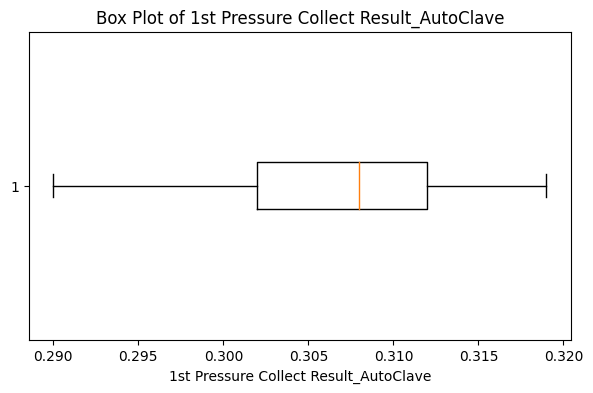

In [31]:
plot_box(train_data, '1st Pressure Collect Result_AutoClave')

boxplot 그래프에 점의 값 존재 x (IQR * 1.5 이상의 값 존재 x)  
-> 이상치 존재 x

<Figure size 1000x500 with 0 Axes>

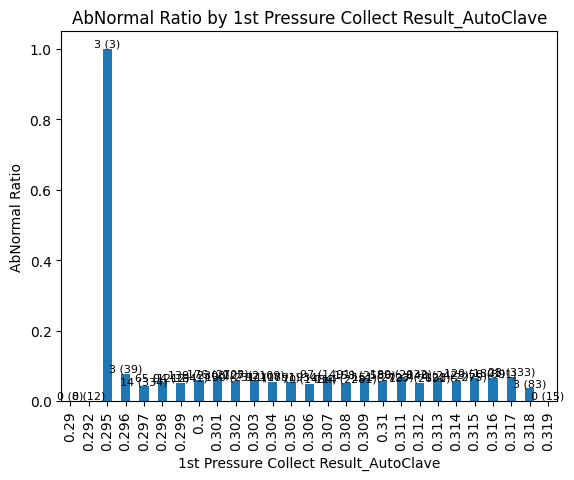

In [32]:
plot_ratio(train_data, '1st Pressure Collect Result_AutoClave')

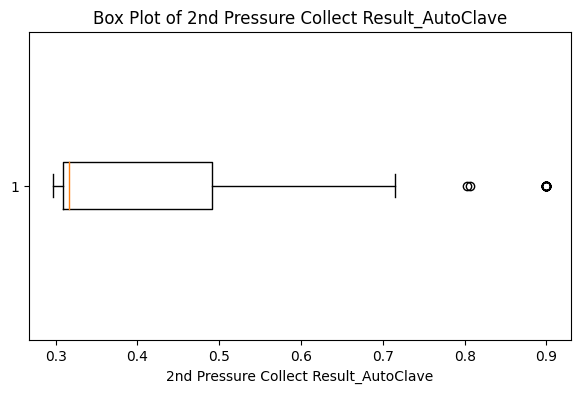

In [33]:
plot_box(train_data, '2nd Pressure Collect Result_AutoClave')

<Figure size 1000x500 with 0 Axes>

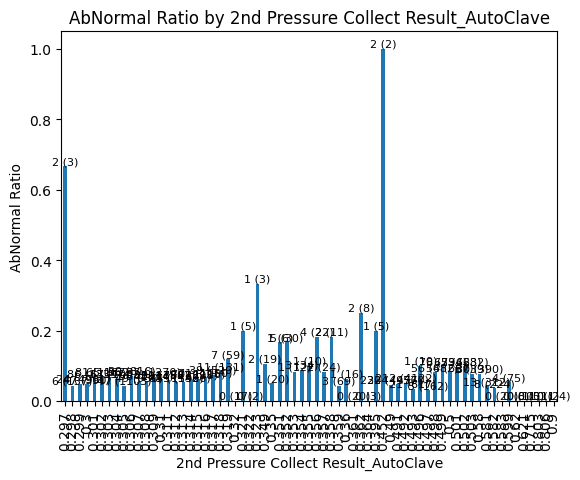

In [34]:
plot_ratio(train_data, '2nd Pressure Collect Result_AutoClave')

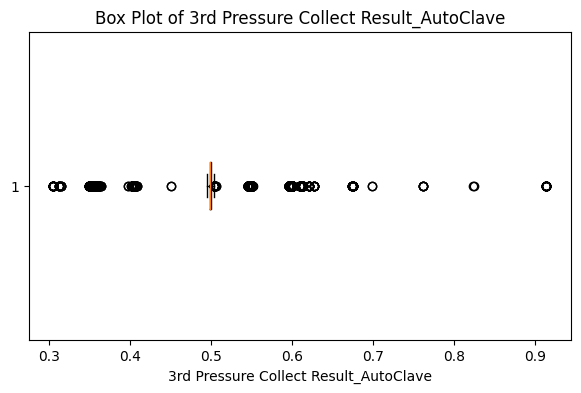

In [35]:
plot_box(train_data, '3rd Pressure Collect Result_AutoClave')

In [36]:
# value_counts_ratio(train_data, '3rd Pressure Collect Result_AutoClave')

<Figure size 1000x500 with 0 Axes>

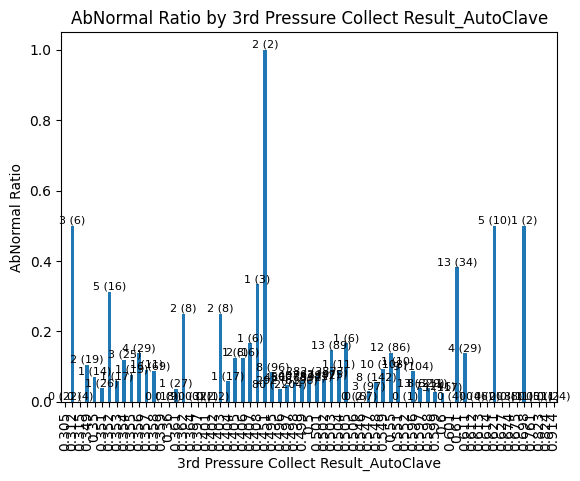

In [37]:
plot_ratio(train_data, '3rd Pressure Collect Result_AutoClave')

압력(Pressure) 1차,2차,3차 변수에 대해서 boxplot과 타겟변수비율을 확인하였을때 유의미함을 찾지 못함  
-> 다른 변수와의 결합으로 유의미해질것으로 판단

In [38]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Model.Suffix_AutoClave
Workorder_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave


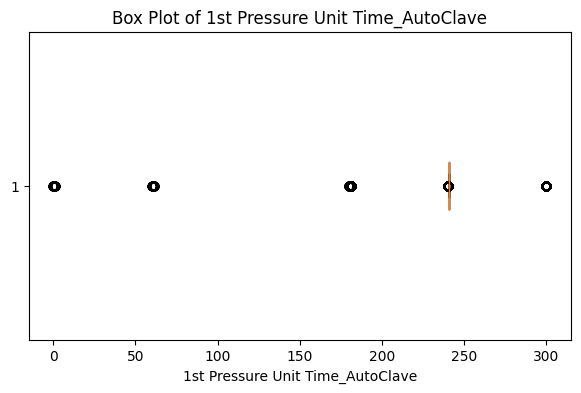

In [39]:
plot_box(train_data, '1st Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

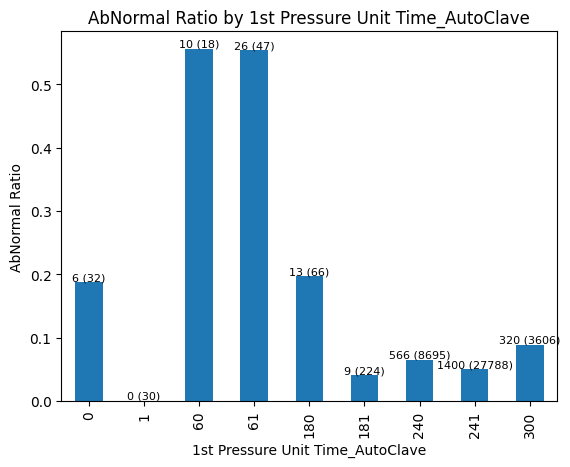

In [40]:
plot_ratio(train_data, '1st Pressure Unit Time_AutoClave')

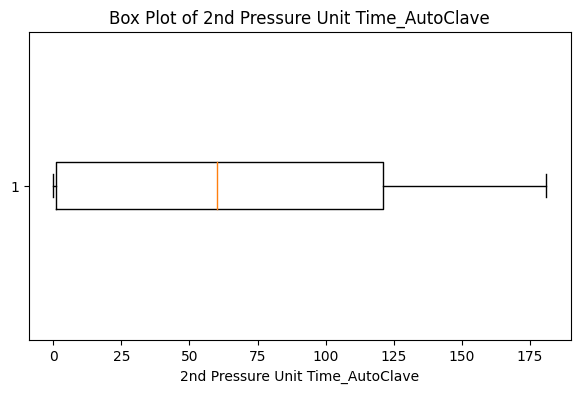

In [41]:
plot_box(train_data, '2nd Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

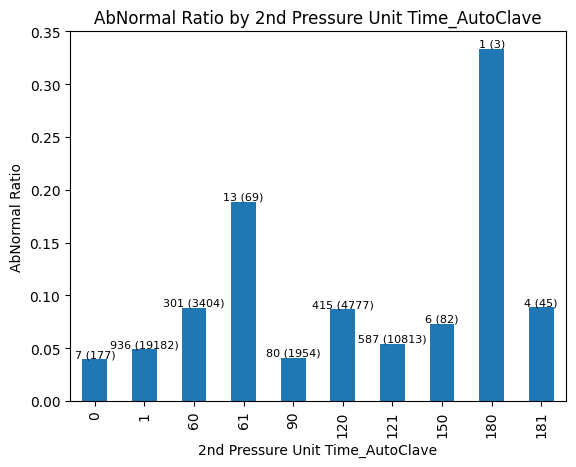

In [42]:
plot_ratio(train_data, '2nd Pressure Unit Time_AutoClave')

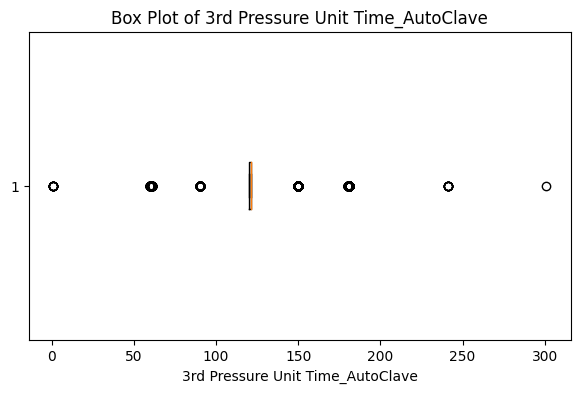

In [43]:
plot_box(train_data, '3rd Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

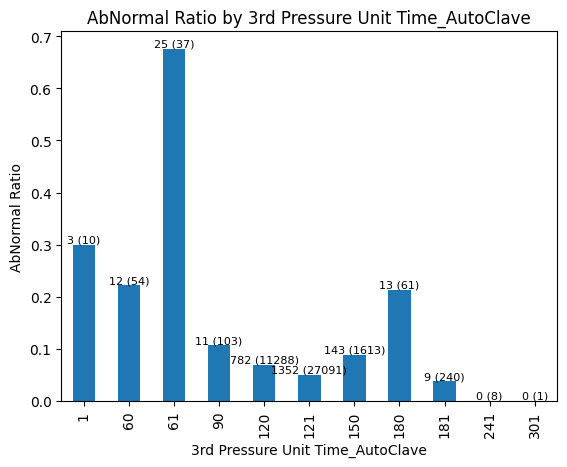

In [44]:
plot_ratio(train_data, '3rd Pressure Unit Time_AutoClave')

In [45]:
summarize_group(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    ])

Grouped by: 1st Pressure Unit Time_AutoClave, 2nd Pressure Unit Time_AutoClave, 3rd Pressure Unit Time_AutoClave

              group  'AdNormal' count     ratio  Total
0        (0, 1, 60)                 2  1.000000      2
1       (0, 61, 60)                 0  0.000000      1
2     (0, 181, 120)                 4  0.137931     29
3         (1, 1, 1)                 0  0.000000      4
4       (1, 1, 241)                 0  0.000000      8
5       (1, 1, 301)                 0  0.000000      1
6     (1, 121, 121)                 0  0.000000      1
7     (1, 181, 181)                 0  0.000000     16
8      (60, 60, 60)                 6  1.000000      6
9    (60, 120, 120)                 2  0.200000     10
10   (60, 120, 180)                 2  1.000000      2
11     (61, 61, 61)                13  1.000000     13
12     (61, 90, 61)                12  0.500000     24
13   (61, 121, 121)                 1  0.100000     10
14    (180, 60, 60)                 1  0.250000      4
15  (1

<Figure size 1000x500 with 0 Axes>

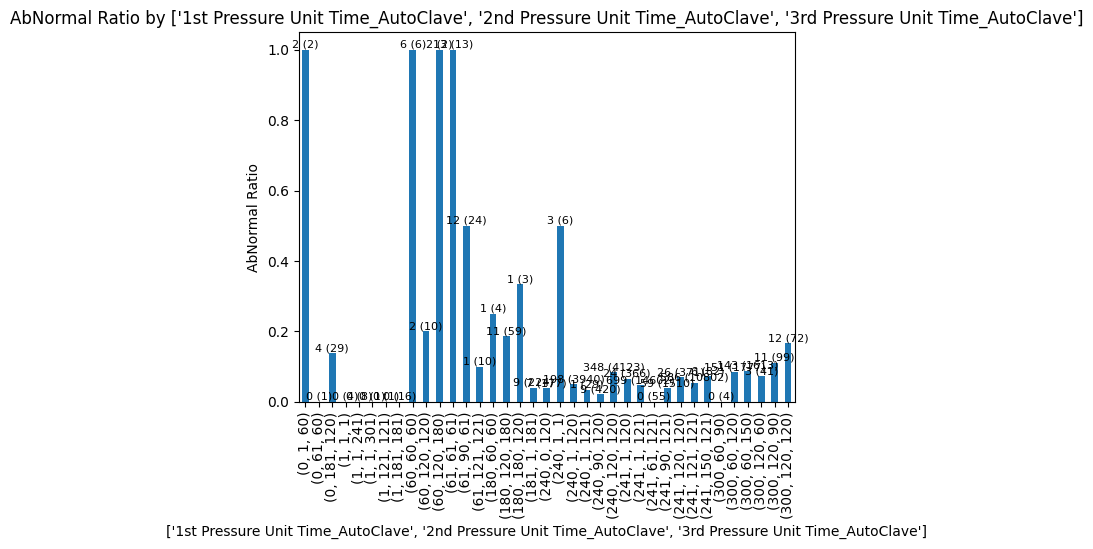

In [46]:
plot_ratio(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    ])

<Figure size 1000x500 with 0 Axes>

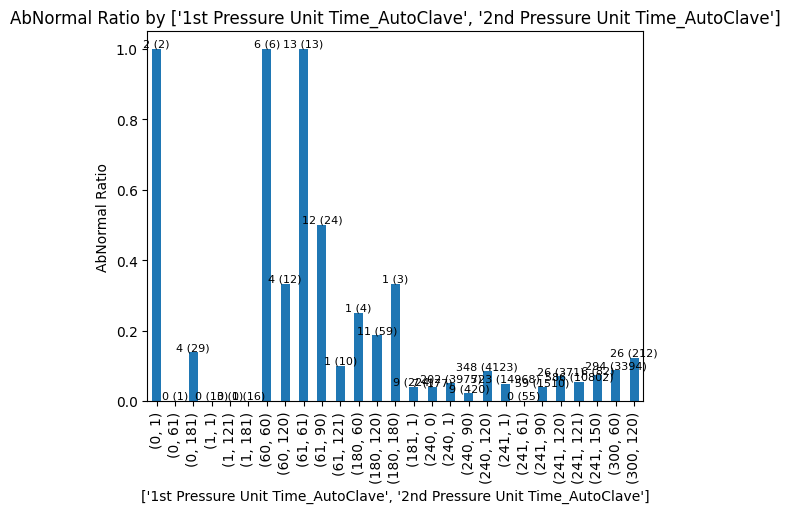

In [47]:
plot_ratio(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    ])

압력 시간간에 그룹화 하였을때 비율값으로 1을 가지는 그룹이 3개 존재  
-> 단일변수보단 결합이나 파생변수 형식으로 활용시 성능향상 기대

In [48]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("필터링된 열 이름:")
for col in Process_Desc_col:
    print(col)

필터링된 열 이름:
Model.Suffix_AutoClave
Workorder_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave


### EDA : Chamber

In [49]:
# 'Chamber'와 '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns
filtered_columns = [col for col in Process_Desc_col if 'Chamber' in col]


print("\n AutoClave 공정 관련 변수 중 Chamber 포함 변수>")
for col in filtered_columns:
    print(col)


 AutoClave 공정 관련 변수 중 Chamber 포함 변수>
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave
